In [3]:
import torch


from trashcan_core.components.data_loader import DataLoader as CustomLoader
from trashcan_core.components.constants import MATERIAL_VERSION_PATH

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 17
BATCH_SIZE = 32
INPUT_SIZE = (128, 128)



def preprocess_batches(x_batches, y_batches):
    """
    Converts a list of batches to PyTorch tensors.
    Assumes batches are lists of tensors with shape: [B, C, H, W].
    """
    x_tensor = torch.cat(x_batches, dim=0)
    y_tensor = torch.cat(y_batches, dim=0)
    return x_tensor, y_tensor


data_loader = CustomLoader(MATERIAL_VERSION_PATH)
data_loader()


def crop(loader, height: int, width: int) -> None:
    def crop_tensor_batch(batch: torch.Tensor) -> torch.Tensor:
        original_height, original_width = batch.shape[-2], batch.shape[-1]

        if height > original_height or width > original_width:
            raise ValueError(
                f"Target dimensions ({height}, {width}) must not exceed the original dimensions ({original_height}, {original_width})."
            )

        top = (original_height - height) // 2
        left = (original_width - width) // 2
        bottom = top + height
        right = left + width

        return batch[:, :, top:bottom, left:right]

    def crop_batches(batches: list) -> list:
        return [crop_tensor_batch(batch) for batch in batches]

    loader.x_train = crop_batches(loader.x_train)
    loader.y_train = crop_batches(loader.y_train)
    loader.x_val = crop_batches(loader.x_val)
    loader.y_val = crop_batches(loader.y_val)

    print(f"Cropped all dataset images to size ({height}, {width}).")


crop(data_loader, 128, 128)





Cropped all dataset images to size (128, 128).


In [8]:
import onnxruntime as ort
import numpy as np
import torch

# Load ONNX model
onnx_model_path = "..\\models\\resunet34v4.onnx"  # Replace with your actual ONNX model file path
ort_session = ort.InferenceSession(onnx_model_path)



In [15]:
# Extract an image (3 x 128 x 128)
image = data_loader.x_train[19][8]  # Example image

# Add batch dimension to the image: shape becomes (1, 3, 128, 128)
image = image.unsqueeze(0)  # Add batch dimension
image_numpy = image.numpy().astype(np.float32)  # Convert to numpy float32

# Run ONNX model inference
outputs = ort_session.run(None, {"input": image_numpy})

# Postprocess the output
# Assume model predicts probabilities for 16 classes
predicted_probs = outputs[0]  # Get the first output (logits/probabilities)
predicted_class = np.argmax(predicted_probs, axis=1)  # Get the most likely class per pixel

# Display results
print(f"Predicted probabilities shape: {predicted_probs.shape}")  # Should be (1, 16, 128, 128)
print(f"Predicted class shape: {predicted_class.shape}")          # Should be (1, 128, 128)


Predicted probabilities shape: (1, 17, 128, 128)
Predicted class shape: (1, 128, 128)


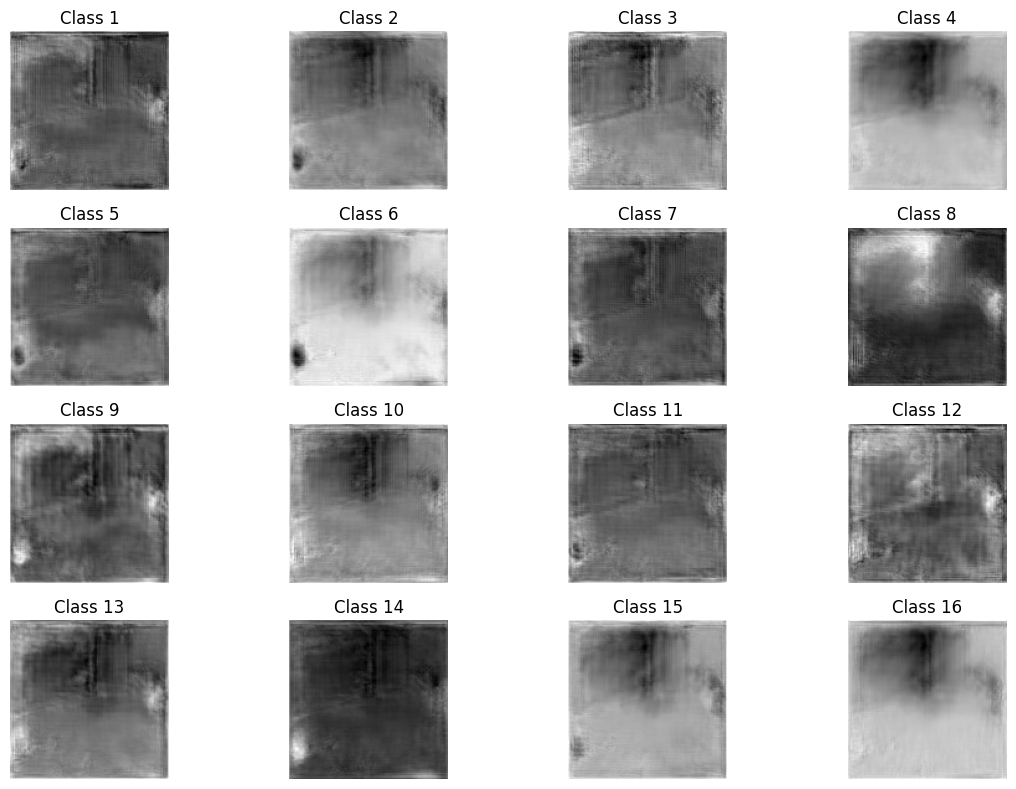

C:\Users\mikol\AppData\Local\Temp\ipykernel_18712\736947988.py:75: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 300 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  hsv_image[..., 0][mask] = hue           # Set the hue for these pixels
C:\Users\mikol\AppData\Local\Temp\ipykernel_18712\736947988.py:75: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 330 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  hsv_image[..., 0][mask] = hue           # Set the hue for these pixels
C:\Users\mikol\AppData\Local\Temp\ipykernel_18712\736947988.py:75: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to in

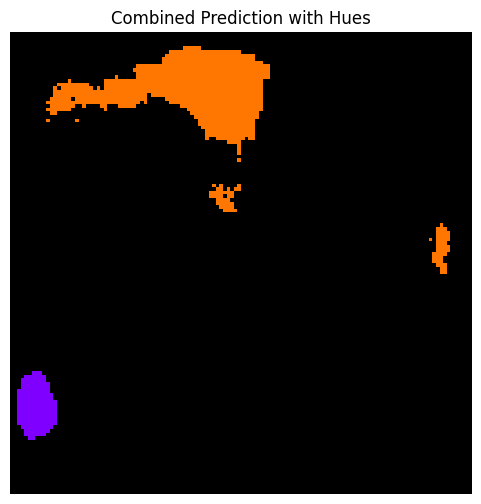

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Hues dictionary provided
HUES = {
    "rov": 30,
    "plant": 120,
    "animal_fish": 180,
    "animal_starfish": 300,
    "animal_shells": 240,
    "animal_crab": 330,
    "animal_eel": 210,
    "animal_etc": 270,
    "trash_etc": 0,
    "trash_fabric": 45,
    "trash_fishing_gear": 90,
    "trash_metal": 15,
    "trash_paper": 60,
    "trash_plastic": 135,
    "trash_rubber": 75,
    "trash_wood": 150,
}

# Define the number of classes
NUM_CLASSES = 16  # You have 16 classes in the model output

plt.figure(figsize=(12, 8))
for i in range(NUM_CLASSES):
    plt.subplot(4, 4, i+1)
    plt.imshow(predicted_probs[0, i], cmap="gray")
    plt.title(f"Class {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Combine the classes into a colored image using HUES
# Initialize a blank image with 3 channels (RGB)

# Hues for each class
HUES = {
    "class_0": 30,  # Distinct for class 0
    "class_1": 120,  # Green for class 1
    "class_2": 180,  # Blue for class 2
    "class_3": 300,  # Magenta for class 3
    "class_4": 240,  # Cyan for class 4
    "class_5": 330,  # Pink-red for class 5
    "class_6": 210,  # Slightly different blue for class 6
    "class_7": 270,  # Purple for class 7
    "class_8": 0,    # Red for class 8
    "class_9": 45,   # Yellow for class 9
    "class_10": 90,  # Green for class 10
    "class_11": 15,  # Orange for class 11
    "class_12": 60,  # Yellow-green for class 12
    "class_13": 135, # Aqua for class 13
    "class_14": 75,  # Olive for class 14
    "class_15": 150, # Light green for class 15
    "class_16": 195, # Custom for class 16
}

# Sample predicted_probs (example: shape [1, NUM_CLASSES, 128, 128])
# Ensure predicted_probs is normalized between 0 and 1
# predicted_probs = <Your model's prediction here>

# Initialize a blank HSV image
hsv_image = np.zeros((128, 128, 3), dtype=np.uint8)

# For each pixel, determine the class with the highest probability
predicted_classes = np.argmax(predicted_probs[0], axis=0)  # Shape [128, 128]

# Assign hues based on the predicted class
for class_idx in range(NUM_CLASSES):
    hue = HUES.get(f"class_{class_idx}", 0)  # Default hue 0 if not in HUES
    mask = predicted_classes == class_idx   # Mask for pixels belonging to this class
    hsv_image[..., 0][mask] = hue           # Set the hue for these pixels
    hsv_image[..., 1][mask] = 255           # Full saturation
    hsv_image[..., 2][mask] = 255           # Full value (brightness)

# Convert HSV to RGB for visualization
rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

# Display the combined image
plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title("Combined Prediction with Hues")
plt.axis('off')
plt.show()



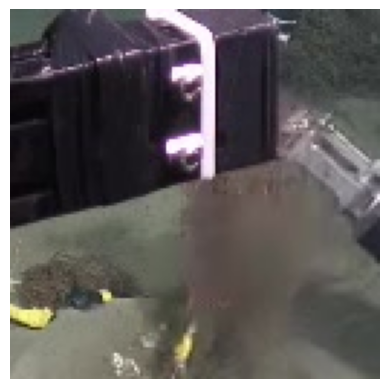

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data_loader.x_train[0][0] is the first image from the dataset
image_tensor = data_loader.x_train[19][8]  # Shape: [C, H, W] (3, 128, 128)

# Convert to numpy array and transpose to HWC format (128, 128, 3)
image_numpy = image_tensor.permute(1, 2, 0).cpu().numpy()

# Clip the pixel values to be in range [0, 1] or [0, 255] depending on the input range
# Assuming the image is in [0, 1] range (if it's normalized)
image_numpy = np.clip(image_numpy, 0, 1)

# Display the image
plt.imshow(image_numpy)
plt.axis('off')  # Hide axes
plt.show()


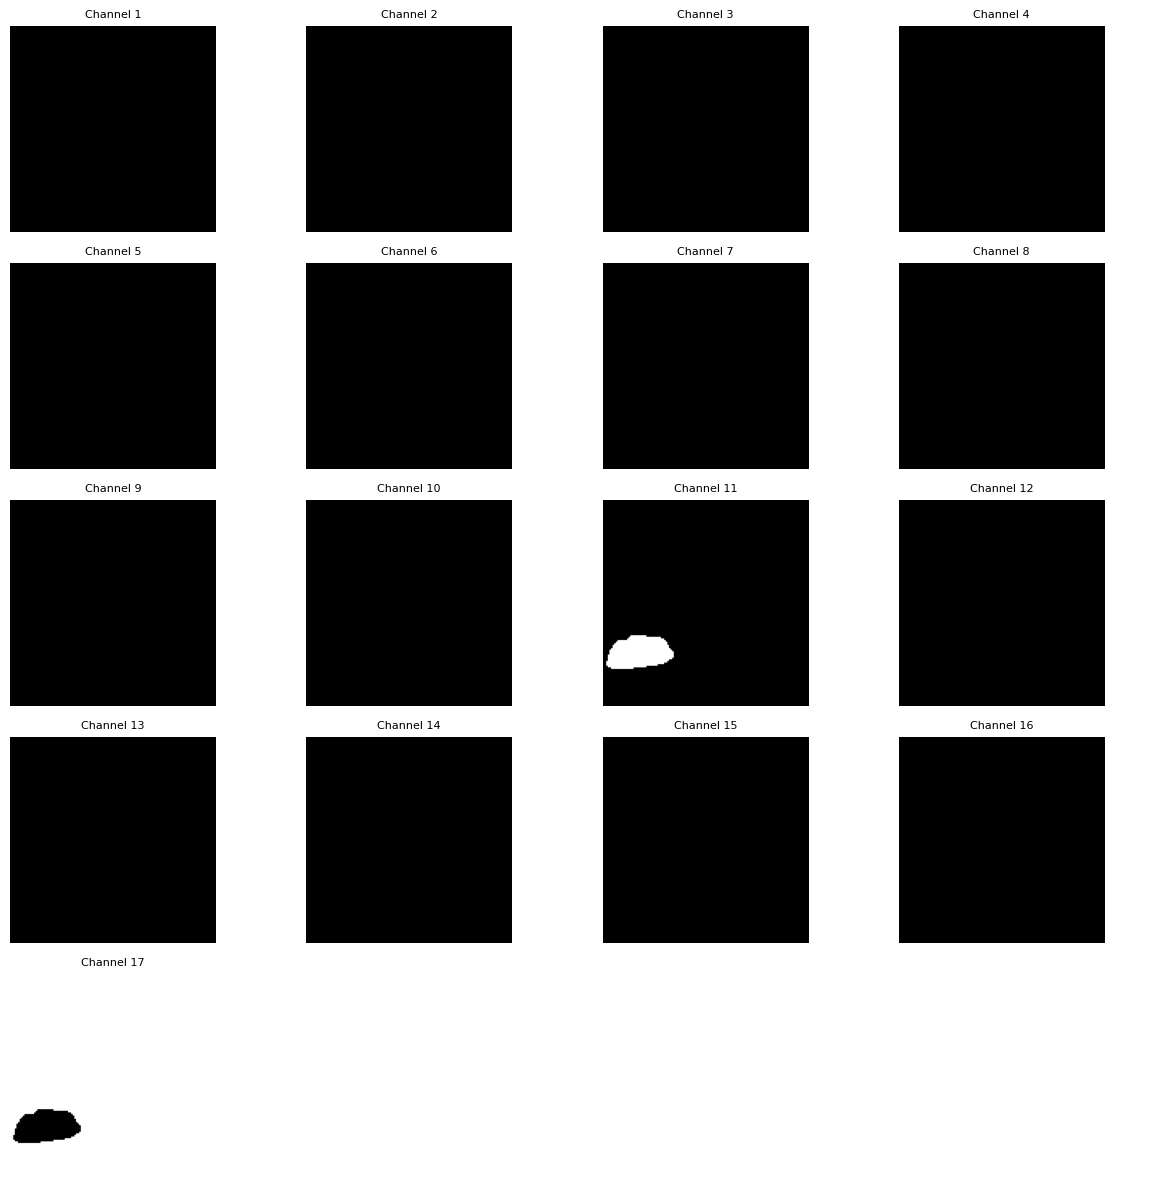

In [18]:
import matplotlib.pyplot as plt
import math

# Number of channels
num_channels = 17  

# Number of rows and columns for the grid
ncols = 4  # Number of columns (adjust as needed for layout)
nrows = math.ceil(num_channels / ncols)  # Compute the number of rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

# Flatten axes for easy iteration
axes = axes.flatten()

for i in range(num_channels):
    # Get the mask for the i-th channel
    mask = data_loader.y_train[19][8][i].cpu().numpy()
    
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f'Channel {i+1}', fontsize=8)
    axes[i].axis('off')

for j in range(num_channels, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()